# Maximum Likelihood Estimation

```{include} _admonition/gpu.md
```

## Overview

This lecture is the extended JAX implementation of [this section](https://python.quantecon.org/mle.html#mle-with-numerical-methods) of [this lecture](https://python.quantecon.org/mle.html).

Please refer that lecture for all background and notation.

Here we will exploit the automatic differentiation capabilities of JAX rather than calculating derivatives by hand.

We'll require the following imports:

In [1]:
import matplotlib.pyplot as plt
from collections import namedtuple
import jax.numpy as jnp
import jax
from statsmodels.api import Poisson

Let's check the GPU we are running

In [2]:
!nvidia-smi

Fri Mar  1 22:30:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P0    37W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


We will use 64 bit floats with JAX in order to increase the precision.

In [3]:
jax.config.update("jax_enable_x64", True)

## MLE with numerical methods (JAX)

Many distributions do not have nice, analytical solutions and therefore require
numerical methods to solve for parameter estimates.

One such numerical method is the Newton-Raphson algorithm.

Let's start with a simple example to illustrate the algorithm.

### A toy model

Our goal is to find the maximum likelihood estimate $\hat{\boldsymbol{\beta}}$.

At $\hat{\boldsymbol{\beta}}$, the first derivative of the log-likelihood
function will be equal to 0.

Let's illustrate this by supposing

$$
\log \mathcal{L(\beta)} = - (\beta - 10) ^2 - 10
$$

Define the function `logL`.

In [4]:
@jax.jit
def logL(β):
    return -(β - 10) ** 2 - 10

To find the value of $\frac{d \log \mathcal{L(\boldsymbol{\beta})}}{d \boldsymbol{\beta}}$, we can use [jax.grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html) which auto-differentiates the given function.

We further use [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) which vectorizes the given function i.e. the function acting upon scalar inputs can now be used with vector inputs.

In [5]:
dlogL = jax.vmap(jax.grad(logL))

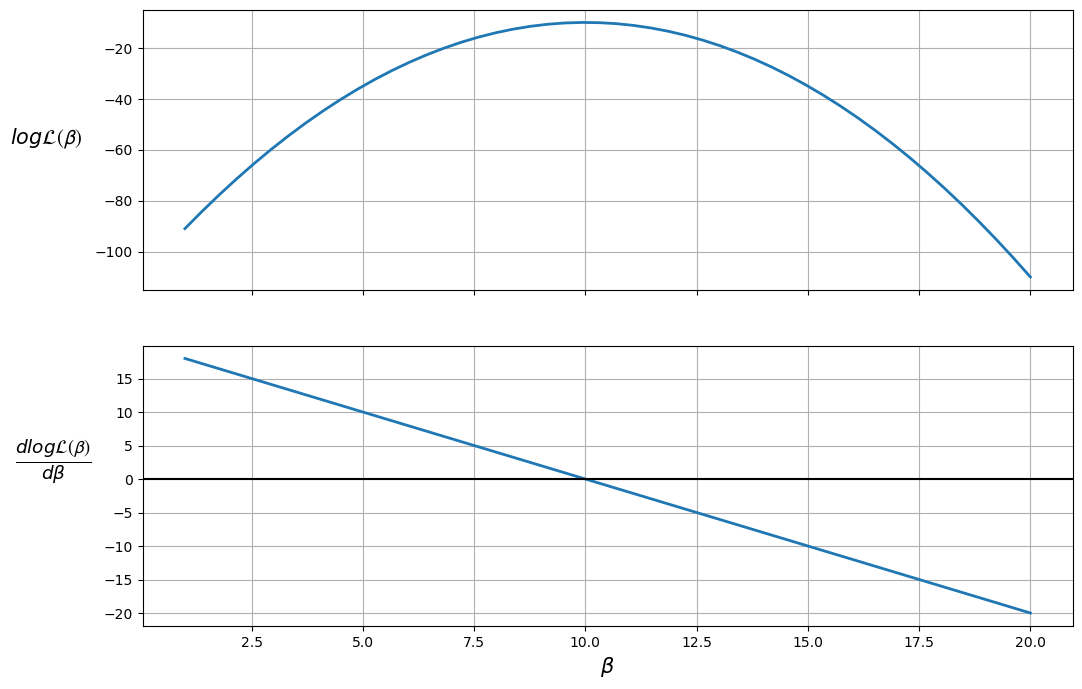

In [6]:
β = jnp.linspace(1, 20)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL(β), lw=2)
ax2.plot(β, dlogL(β), lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)

ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

The plot shows that the maximum likelihood value (the top plot) occurs
when $\frac{d \log \mathcal{L(\boldsymbol{\beta})}}{d \boldsymbol{\beta}} = 0$ (the bottom
plot).

Therefore, the likelihood is maximized when $\beta = 10$.

We can also ensure that this value is a *maximum* (as opposed to a
minimum) by checking that the second derivative (slope of the bottom
plot) is negative.

The Newton-Raphson algorithm finds a point where the first derivative is
0.

To use the algorithm, we take an initial guess at the maximum value,
$\beta_0$ (the OLS parameter estimates might be a reasonable
guess).

Then we use the updating rule involving gradient information to iterate the algorithm until the error is sufficiently small or the algorithm reaches the maximum number of iterations.

Please refer to [this section](https://python.quantecon.org/mle.html#mle-with-numerical-methods) for the detailed algorithm.

### A Poisson model

Let's have a go at implementing the Newton-Raphson algorithm to calculate the maximum likelihood estimations of a Poisson  regression.

The Poisson regression has a joint pmf:

$$
f(y_1, y_2, \ldots, y_n \mid \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n; \boldsymbol{\beta})
    = \prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}

$$

$$
\text{where}\ \mu_i
     = \exp(\mathbf{x}_i' \boldsymbol{\beta})
     = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})
$$

We create a `namedtuple` to store the observed values

In [7]:
RegressionModel = namedtuple('RegressionModel', ['X', 'y'])

def create_regression_model(X, y):
    n, k = X.shape
    # Reshape y as a n_by_1 column vector
    y = y.reshape(n, 1)
    X, y = jax.device_put((X, y))
    return RegressionModel(X=X, y=y)

The log likelihood function of the Poisson regression is

$$
\underset{\beta}{\max} \Big(
\sum_{i=1}^{n} y_i \log{\mu_i} -
\sum_{i=1}^{n} \mu_i -
\sum_{i=1}^{n} \log y! \Big)
$$

The full derivation can be found [here](https://python.quantecon.org/mle.html#id2).

The log likelihood function involves factorial, but JAX doesn't have a readily available implementation to compute factorial directly.

In order to compute the factorial efficiently such that we can JIT it, we use

$$
    n! = e^{\log(\Gamma(n+1))}
$$

since [jax.lax.lgamma](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.lgamma.html) and [jax.lax.exp](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.exp.html) are available.

The following function `jax_factorial` computes the factorial using this idea.

Let's define this function in Python

In [8]:
@jax.jit
def _factorial(n):
    return jax.lax.exp(jax.lax.lgamma(n + 1.0)).astype(int)

jax_factorial = jax.vmap(_factorial)

Now we can define the log likelihood function in Python

In [9]:
@jax.jit
def poisson_logL(β, model):
    y = model.y
    μ = jnp.exp(model.X @ β)
    return jnp.sum(model.y * jnp.log(μ) - μ - jnp.log(jax_factorial(y)))

To find the gradient of the `poisson_logL`, we again use [jax.grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html).

According to [the documentation](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev),

* `jax.jacfwd` uses forward-mode automatic differentiation, which is more efficient for “tall” Jacobian matrices, while
* `jax.jacrev` uses reverse-mode, which is more efficient for “wide” Jacobian matrices.

(The documentation also states that when matrices that are near-square, `jax.jacfwd` probably has an edge over `jax.jacrev`.)

Therefore, to find the Hessian, we can directly use `jax.jacfwd`.

In [10]:
G_poisson_logL = jax.grad(poisson_logL)
H_poisson_logL = jax.jacfwd(G_poisson_logL)

Our function `newton_raphson` will take a `RegressionModel` object
that has an initial guess of the parameter vector $\boldsymbol{\beta}_0$.

The algorithm will update the parameter vector according to the updating
rule, and recalculate the gradient and Hessian matrices at the new
parameter estimates.

In [11]:
def newton_raphson(model, β, tol=1e-3, max_iter=100, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached
    while jnp.any(error > tol) and i < max_iter:
        H, G = jnp.squeeze(H_poisson_logL(β, model)), G_poisson_logL(β, model)
        β_new = β - (jnp.dot(jnp.linalg.inv(H), G))
        error = jnp.abs(β_new - β)
        β = β_new

        if display:
            β_list = [f'{t:.3}' for t in list(β.flatten())]
            update = f'{i:<13}{poisson_logL(β, model):<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {β.flatten()}')

    return β

Let's try out our algorithm with a small dataset of 5 observations and 3
variables in $\mathbf{X}$.

In [12]:
X = jnp.array([[1, 2, 5],
               [1, 1, 3],
               [1, 4, 2],
               [1, 5, 2],
               [1, 3, 1]])

y = jnp.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_β = jnp.array([0.1, 0.1, 0.1]).reshape(X.shape[1], 1)

# Create an object with Poisson model values
poi = create_regression_model(X, y)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, init_β, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------


0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']


6            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 7
β_hat = [-6.07848573  0.9334028   0.84329677]


As this was a simple model with few observations, the algorithm achieved
convergence in only 7 iterations.

The gradient vector should be close to 0 at $\hat{\boldsymbol{\beta}}$

In [13]:
G_poisson_logL(β_hat, poi)

Array([[-2.56406008e-13],
       [-6.50202114e-13],
       [-5.05540054e-13]], dtype=float64)

## MLE with `statsmodels`

We’ll use the Poisson regression model in `statsmodels` to verify the results
obtained using JAX.

`statsmodels` uses the same algorithm as above to find the maximum
likelihood estimates.

Now, as `statsmodels` accepts only NumPy arrays, we can use the `__array__` method
of JAX arrays to convert it to NumPy arrays.

In [14]:
X_numpy = X.__array__()
y_numpy = y.__array__()

In [15]:
stats_poisson = Poisson(y_numpy, X_numpy).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Mar 2024   Pseudo R-squ.:                  0.2546
Time:                        22:30:13   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

The benefit of writing our own procedure, relative to statsmodels is that

* we can exploit the power of the GPU and
* we learn the underlying methodology, which can be extended to complex situations where no existing routines are available.

```{exercise-start}
:label: newton_mle1
```

We define a quadratic model for a single explanatory variable by

$$
    \log(\lambda_t) = \beta_0 + \beta_1 x_t + \beta_2 x_{t}^2
$$

We calculate the mean on the original scale instead of the log scale by exponentiating both sides of the above equation, which gives

```{math}
:label: lambda_mle
    \lambda_t = \exp(\beta_0 + \beta_1 x_t + \beta_2 x_{t}^2)
```

Simulate the values of $x_t$ by sampling from a normal distribution and $\lambda_t$ by using {eq}`lambda_mle` and the following constants:

$$
    \beta_0 = -2.5,
    \quad
    \beta_1 = 0.25,
    \quad
    \beta_2 = 0.5
$$

Try to obtain the approximate values of $\beta_0,\beta_1,\beta_2$, by simulating a Poisson Regression Model such that

$$
      y_t \sim {\rm Poisson}(\lambda_t)
      \quad \text{for all } t.
$$

Using our `newton_raphson` function on the data set $X = [1, x_t, x_t^{2}]$ and
$y$, obtain the maximum likelihood estimates of $\beta_0,\beta_1,\beta_2$.

With a sufficient large sample size, you should approximately
recover the true values of of these parameters.


```{exercise-end}
```

```{solution-start} newton_mle1
:class: dropdown
```

Let's start by defining "true" parameter values.

In [16]:
β_0 = -2.5
β_1 = 0.25
β_2 = 0.5

To simulate the model, we sample 500,000 values of $x_t$ from the standard normal distribution.

In [17]:
seed = 32
shape = (500_000, 1)
key = jax.random.PRNGKey(seed)
x = jax.random.normal(key, shape)

We compute $\lambda$ using {eq}`lambda_mle`

In [18]:
λ = jnp.exp(β_0 + β_1 * x + β_2 * x**2)

Let's define $y_t$ by sampling from a Poisson distribution with mean as $\lambda_t$.

In [19]:
y = jax.random.poisson(key, λ, shape)

Now let's try to recover the true parameter values using the Newton-Raphson
method described above.

In [20]:
X = jnp.hstack((jnp.ones(shape), x, x**2))

# Take a guess at initial βs
init_β = jnp.array([0.1, 0.1, 0.1]).reshape(X.shape[1], 1)

# Create an object with Poisson model values
poi = create_regression_model(X, y)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, init_β, tol=1e-5, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------


0            -4.5444745e+07  ['-1.49', '0.312', '0.794']
1            -1.6303734e+07  ['-2.42', '0.311', '0.79']
2            -5689832.6      ['-3.22', '0.31', '0.78']
3            -1869457.7      ['-3.73', '0.306', '0.756']
4            -510284.64      ['-3.71', '0.297', '0.705']
5            -28066.381      ['-3.2', '0.283', '0.63']
6            127470.33       ['-2.77', '0.268', '0.563']
7            163044.64       ['-2.57', '0.257', '0.52']
8            166608.12       ['-2.51', '0.252', '0.503']
9            166666.4        ['-2.5', '0.251', '0.5']
10           166666.42       ['-2.5', '0.251', '0.5']
11           166666.42       ['-2.5', '0.251', '0.5']
Number of iterations: 12
β_hat = [-2.50016027  0.25079345  0.50008394]


The maximum likelihood estimates are similar to the true parameter values.

```{solution-end}
```